# Session 2 - Instrumental Variables

*Matteo Courthoud*

## Contents
  
- [Simple Linear Regression](#/2)  
- [Extending the Linear Regression Model](#/16)  
- [Endogeneity](#/20)  
- [Matrix Algebra](#/34)

In [1]:
# Import everything
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## 2.1 Simple Linear Regression

[*go to index*](#/1)

In [Acemoglu, Johnson, Robinson (2002), "*The Colonial Origins of Comparative Development*"](https://economics.mit.edu/files/4123) the authors wish to determine whether or not differences in institutions can help to explain observed economic outcomes.

How do we measure *institutional differences* and *economic outcomes*?

In this paper,

- economic outcomes are proxied by log GDP per capita in 1995, adjusted for exchange rates.  
- institutional differences are proxied by an index of protection against expropriation on average over 1985-95, constructed by the [Political Risk Services Group](https://www.prsgroup.com/).  


These variables and other data used in the paper are available for download on Daron Acemoglu’s [webpage](https://economics.mit.edu/faculty/acemoglu/data/ajr2001).

The original dataset in in Stata `.dta` format but has been converted to `.csv`.

First, let's load the data and have a look at it.

In [3]:
# Load Acemoglu Johnson Robinson Dataset
df = pd.read_csv('data/AJR02.csv',index_col=0)
df.head()

,GDP,Exprop,Mort,Latitude,Neo,Africa,Asia,Namer,Samer,logMort,Latitude2
1,8.39,6.50,78.20,0.3111,0,1,0,0,0,4.359270,0.096783
2,7.77,5.36,280.00,0.1367,0,1,0,0,0,5.634790,0.018687
3,9.13,6.39,68.90,0.3778,0,0,0,0,1,4.232656,0.142733
4,9.90,9.32,8.55,0.3000,1,0,0,0,0,2.145931,0.090000
5,9.29,7.50,85.00,0.2683,0,0,0,1,0,4.442651,0.071985


Let’s use a scatterplot to see whether any obvious relationship exists between GDP per capita and the protection against expropriation.

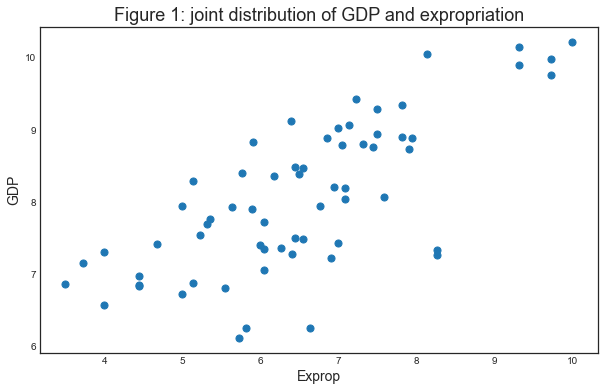

In [4]:
# Plot relationship between GDP and expropriation rate
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 1: joint distribution of GDP and expropriation')
df.plot(x='Exprop', y='GDP', kind='scatter', s=50, ax=ax);

The plot shows a fairly strong positive relationship between
protection against expropriation and log GDP per capita.

Specifically, if higher protection against expropriation is a measure of
institutional quality, then better institutions appear to be positively
correlated with better economic outcomes (higher GDP per capita).

Given the plot, choosing a linear model to describe this relationship
seems like a reasonable assumption.

We can write our model as

$$
{GDP}_i = \beta_0 + \beta_1 {Exprop}_i + \varepsilon_i
$$

where:

- $ \beta_0 $ is the intercept of the linear trend line on the
  y-axis  
- $ \beta_1 $ is the slope of the linear trend line, representing
  the *marginal effect* of protection against risk on log GDP per
  capita  
- $ \varepsilon_i $ is a random error term (deviations of observations from
  the linear trend due to factors not included in the model)  

The most common technique to estimate the parameters ($ \beta $’s)
of the linear model is Ordinary Least Squares (OLS).

As the name implies, an OLS model is solved by finding the parameters
that minimize *the sum of squared residuals*, i.e.

$$
\underset{\hat{\beta}}{\min} \sum^N_{i=1}{\hat{u}^2_i}
$$

where $ \hat{u}_i $ is the difference between the observation and
the predicted value of the dependent variable.

To estimate the constant term $ \beta_0 $, we need to add a column
of 1’s to our dataset (consider the equation if $ \beta_0 $ was
replaced with $ \beta_0 x_i $ and $ x_i = 1 $)

Now we can construct our model in `statsmodels` using the OLS function.

We will use `pandas` dataframes with `statsmodels`, however standard arrays can also be used as arguments

In [5]:
# Regress GDP on Expropriation Rate
reg1 = sm.OLS.from_formula('GDP ~ Exprop', df)
type(reg1)

statsmodels.regression.linear_model.OLS

So far we have simply constructed our model.

We need to use `.fit()` to obtain parameter estimates
$ \hat{\beta}_0 $ and $ \hat{\beta}_1 $

In [6]:
# Fit regression
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

We now have the fitted regression model stored in `results`.

To view the OLS regression results, we can call the `.summary()`
method.

Note that an observation was mistakenly dropped from the results in the
original paper (see the note located in maketable2.do from Acemoglu’s webpage), and thus the
coefficients differ slightly.

In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GDP   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     72.71
Date:                Thu, 23 Sep 2021   Prob (F-statistic):           4.84e-12
Time:                        15:32:21   Log-Likelihood:                -68.214
No. Observations:                  64   AIC:                             140.4
Df Residuals:                      62   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6609      0.409     11.402      0.000       3.844       5.478
Exprop         0.5220      0.061      8.527      0.000       0.400       0.644
==============================================================================
Omnibus:                        7.134   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.698
Skew:                          -0.784   Prob(JB):                       0.0351
Kurtosis:                       3.234   Cond. No.                         31.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From our results, we see that

- The intercept $ \hat{\beta}_0 = 4.63 $.  
- The slope $ \hat{\beta}_1 = 0.53 $.  
- The positive $ \hat{\beta}_1 $ parameter estimate implies that.
  institutional quality has a positive effect on economic outcomes, as
  we saw in the figure.  
- The p-value of 0.000 for $ \hat{\beta}_1 $ implies that the
  effect of institutions on GDP is statistically significant (using p <
  0.05 as a rejection rule).  
- The R-squared value of 0.611 indicates that around 61% of variation
  in log GDP per capita is explained by protection against
  expropriation.  

Using our parameter estimates, we can now write our estimated
relationship as

$$
\widehat{GDP}_i = 4.63 + 0.53 \ {Exprop}_i
$$

This equation describes the line that best fits our data, as shown in
Figure 2.

We can use this equation to predict the level of log GDP per capita for
a value of the index of expropriation protection.

For example, for a country with an index value of 6.51 (the average for
the dataset), we find that their predicted level of log GDP per capita
in 1995 is 8.09.

In [8]:
mean_expr = np.mean(df['Exprop'])
mean_expr

6.5160937500000005

In [9]:
predicted_logpdp95 = results.params[0] + results.params[1] * mean_expr
predicted_logpdp95

8.062499999999996

An easier (and more accurate) way to obtain this result is to use
`.predict()` and set $ constant = 1 $ and
$ {Exprop}_i = mean\_expr $

In [ ]:
results.predict(exog=[1, mean_expr])

We can obtain an array of predicted $ {GDP}_i $ for every value
of $ {Exprop}_i $ in our dataset by calling `.predict()` on our
results.

Plotting the predicted values against $ {Exprop}_i $ shows that the
predicted values lie along the linear line that we fitted above.

The observed values of $ {GDP}_i $ are also plotted for
comparison purposes

In [10]:
# Make first new figure
def make_new_fig_2():

    # Init figure
    fig, ax = plt.subplots(1,1)
    ax.set_title('Figure 2: OLS predicted values')

    # Drop missing observations from whole sample
    df_plot = df.dropna(subset=['GDP', 'Exprop'])
    sns.regplot(x=df_plot['Exprop'], y=df_plot['GDP'], ax=ax, order=1, ci=None, line_kws={'color':'r'})

    ax.legend(['predicted', 'observed'])
    ax.set_xlabel('Exprop')
    ax.set_ylabel('GDP')
    plt.show()

ERROR! Session/line number was not unique in

 database. History logging moved to new session 103


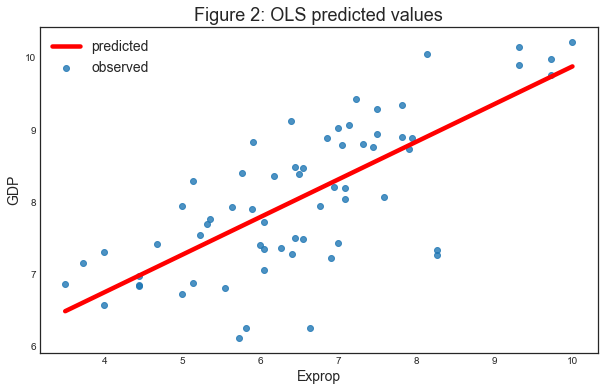

In [11]:
make_new_fig_2()

## 2.2 Extending the Linear Regression Model

[*go to index*](#/1)

So far we have only accounted for institutions affecting economic performance - almost certainly there are numerous other factors affecting GDP that are not included in our model.

Leaving out variables that affect $ GDP_i $ will result in **omitted variable bias**, yielding biased and inconsistent parameter estimates.

We can extend our bivariate regression model to a **multivariate regression model** by adding in other factors that may affect $ GDP_i $.

[[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) consider other factors such as:

- the effect of climate on economic outcomes; latitude is used to proxy
  this  
- differences that affect both economic performance and institutions,
  eg. cultural, historical, etc.; controlled for with the use of
  continent dummies  

Let’s estimate some of the extended models considered in the paper
(Table 2) using data from `maketable2.dta`

In [12]:
# Add constant term to dataset
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = df[['const', 'Exprop']]
X2 = df[['const', 'Exprop', 'Latitude', 'Latitude2']]
X3 = df[['const', 'Exprop', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']]

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df['GDP'], X1, missing='drop').fit()
reg2 = sm.OLS(df['GDP'], X2, missing='drop').fit()
reg3 = sm.OLS(df['GDP'], X3, missing='drop').fit()

Now that we have fitted our model, we will use `summary_col` to
display the results in a single table (model numbers correspond to those
in the paper)

In [13]:
info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1','Model 2','Model 3'],
                            info_dict=info_dict,
                            regressor_order=['const','Exprop','Latitude','Latitude2'])

results_table

,Model 1,Model 2,Model 3
const,4.66***,4.55***,5.95***
,(0.41),(0.45),(0.68)
Exprop,0.52***,0.49***,0.40***
,(0.06),(0.07),(0.06)
Latitude,,2.16,0.42
,,(1.68),(1.47)
Latitude2,,-2.12,0.44
,,(2.86),(2.48)
Africa,,,-1.06**
,,,(0.41)


## 2.3 Endogeneity

[*go to index*](#/1)

As [[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) discuss, the OLS models likely suffer from **endogeneity** issues, resulting in biased and inconsistent model estimates.

Namely, there is likely a two-way relationship between institutions an economic outcomes:

- richer countries may be able to afford or prefer better institutions  
- variables that affect income may also be correlated with institutional differences  
- the construction of the index may be biased; analysts may be biased towards seeing countries with higher income having better institutions  

To deal with endogeneity, we can use **two-stage least squares (2SLS) regression**, which is an extension of OLS regression.

This method requires replacing the endogenous variable $ {Exprop}_i $ with a variable that is:

1. correlated with $ {Exprop}_i $  
1. not correlated with the error term (ie. it should not directly affect the dependent variable, otherwise it would be correlated with $ u_i $ due to omitted variable bias)  

We can write our model as

$$
{GDP}_i = \beta_0 + \beta_1 {Exprop}_i + \varepsilon_i \\
{Exprop}_i = \delta_0 + \delta_1 {logMort}_i + v_i
$$

The new set of regressors `logMort` is called an **instrument**, which aims to remove endogeneity in our proxy of institutional differences.

The main contribution of [[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) is the use of settler mortality rates to instrument for institutional differences.

They hypothesize that higher mortality rates of colonizers led to the establishment of institutions that were more extractive in nature (less protection against expropriation), and these institutions still persist today.

Using a scatterplot (Figure 3 in [[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001)), we can see protection against expropriation is negatively correlated with settler mortality rates, coinciding with the authors’ hypothesis and satisfying the first condition of a valid instrument.

In [14]:
# Dropping NA's is required to use numpy's polyfit
df2 = df.dropna(subset=['logMort', 'Exprop'])
X = df2['logMort']
y = df2['Exprop']

In [15]:
# Make new figure 2
def make_new_figure_2():

    # Init figure
    fig, ax = plt.subplots(1,1)
    ax.set_title('Figure 3: First-stage')

    # Fit a linear trend line
    sns.regplot(x=X, y=y, ax=ax, order=1, scatter=True, ci=None, line_kws={"color": "r"})

    ax.set_xlim([1.8,8.4])
    ax.set_ylim([3.3,10.4])
    ax.set_xlabel('Log of Settler Mortality')
    ax.set_ylabel('Average Expropriation Risk 1985-95');

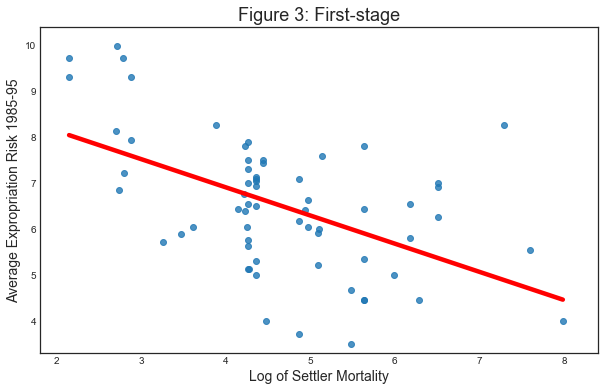

In [16]:
make_new_figure_2()

The second condition may not be satisfied if settler mortality rates in the 17th to 19th centuries have a direct effect on current GDP (in addition to their indirect effect through institutions).

For example, settler mortality rates may be related to the current disease environment in a country, which could affect current economic performance.

[[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) argue this is unlikely because:

- The majority of settler deaths were due to malaria and yellow fever
  and had a limited effect on local people.  
- The disease burden on local people in Africa or India, for example,
  did not appear to be higher than average, supported by relatively
  high population densities in these areas before colonization.  


As we appear to have a valid instrument, we can use 2SLS regression to
obtain consistent and unbiased parameter estimates.

### First stage

The first stage involves regressing the endogenous variable
($ {Exprop}_i $) on the instrument.

The instrument is the set of all exogenous variables in our model (and
not just the variable we have replaced).

Using model 1 as an example, our instrument is simply a constant and
settler mortality rates $ {logMort}_i $.

Therefore, we will estimate the first-stage regression as

$$
{Exprop}_i = \delta_0 + \delta_1 {logMort}_i + v_i
$$

In [17]:
# Add a constant variable
df['const'] = 1

# Fit the first stage regression and print summary
results_fs = sm.OLS(df['Exprop'],
                    df.loc[:,['const', 'logMort']],
                    missing='drop').fit()
results_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Exprop   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     23.34
Date:                Thu, 23 Sep 2021   Prob (F-statistic):           9.27e-06
Time:                        15:32:21   Log-Likelihood:                -104.69
No. Observations:                  64   AIC:                             213.4
Df Residuals:                      62   BIC:                             217.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3659      0.611     15.339      0.000       8.145      10.586
logMort       -0.6133      0.127     -4.831      0.000      -0.867      -0.360
==============================================================================
Omnibus:                        0.047   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.977   Jarque-Bera (JB):                0.154
Skew:                           0.060   Prob(JB):                        0.926
Kurtosis:                       2.792   Cond. No.                         19.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Second stage

We need to retrieve the predicted values of $ {Exprop}_i $ using
`.predict()`.

We then replace the endogenous variable $ {Exprop}_i $ with the
predicted values $ \widehat{Exprop}_i $ in the original linear model.

Our second stage regression is thus

$$
{GDP}_i = \beta_0 + \beta_1 \widehat{Exprop}_i + u_i
$$

In [18]:
# Second stage
df['predicted_Exprop'] = results_fs.predict()
results_ss = sm.OLS.from_formula('GDP ~ predicted_Exprop', df).fit()

# Print
results_ss.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GDP   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     53.24
Date:                Thu, 23 Sep 2021   Prob (F-statistic):           6.58e-10
Time:                        15:32:21   Log-Likelihood:                -73.208
No. Observations:                  64   AIC:                             150.4
Df Residuals:                      62   BIC:                             154.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0448      0.830      2.463      0.017       0.385       3.705
predicted_Exprop     0.9235      0.127      7.297      0.000       0.671       1.177
==============================================================================
Omnibus:                       10.463   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.693
Skew:                          -0.806   Prob(JB):                      0.00476
Kurtosis:                       4.188   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The second-stage regression results give us an unbiased and consistent
estimate of the effect of institutions on economic outcomes.

The result suggests a stronger positive relationship than what the OLS
results indicated.

Note that while our parameter estimates are correct, our standard errors
are not and for this reason, computing 2SLS ‘manually’ (in stages with
OLS) is not recommended.

We can correctly estimate a 2SLS regression in one step using the
[linearmodels](https://github.com/bashtage/linearmodels) package, an extension of `statsmodels`

Note that when using `IV2SLS`, the exogenous and instrument variables
are split up in the function arguments (whereas before the instrument
included exogenous variables)

In [19]:
# IV regression
iv = IV2SLS(dependent=df['GDP'],
            exog=df['const'],
            endog=df['Exprop'],
            instruments=df['logMort']).fit()

# Print
iv.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                    GDP   R-squared:                      0.2205
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2079
No. Observations:                  64   F-statistic:                    29.811
Date:                Thu, Sep 23 2021   P-value (F-stat)                0.0000
Time:                        15:32:21   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2.0448     1.1273     1.8139     0.0697     -0.1647      4.2542
Exprop         0.9235     0.1691     5.4599     0.0000      0.5920      1.2550
==============================================================================

Endogenous: Exprop
Instruments: logMort
Robust Covariance (Heteroskedastic)
Debiased: False
"""

Given that we now have consistent and unbiased estimates, we can infer
from the model we have estimated that institutional differences
(stemming from institutions set up during colonization) can help
to explain differences in income levels across countries today.

[[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) use a marginal effect of 0.94 to calculate that the
difference in the index between Chile and Nigeria (ie. institutional
quality) implies up to a 7-fold difference in income, emphasizing the
significance of institutions in economic development.

## 2.4 Matrix Algebra

[*go to index*](#/1)

The OLS parameter $ \beta $ can also be estimated using matrix
algebra and `numpy`.

The linear equation we want to estimate is (written in matrix form)

$$
y = X\beta + \varepsilon
$$

In [20]:
# Init 
X = df[['const', 'Exprop']].values
Z = df[['const', 'logMort']].values
y = df['GDP'].values

To solve for the unknown parameter $ \beta $, we want to minimize
the sum of squared residuals

$$
\underset{\hat{\beta}}{\min} \ \hat{\varepsilon}'\hat{\varepsilon}
$$

Rearranging the first equation and substituting into the second
equation, we can write

$$
\underset{\hat{\beta}}{\min} \ (Y - X\hat{\beta})' (Y - X\hat{\beta})
$$

Solving this optimization problem gives the solution for the
$ \hat{\beta} $ coefficients

$$
\hat{\beta} = (X'X)^{-1}X'y
$$

In [21]:
# Compute beta OLS
beta_OLS = inv(X.T @ X) @ X.T @ y

print(beta_OLS)

[4.66087966 0.52203367]


As we as see above, the OLS coefficient might suffer from endogeneity bias. We can solve the issue by instrumenting the predicted average expropriation rate with the average settler mortality.

If we define settler mortality as $Z$, our full model is

$$
y = X\beta + \varepsilon \\
X = Z\gamma + \mu
$$

Where we refer to the second equation as second stage and to the first equation as the reduced form equation. In our case, since the number of endogenous varaibles is equal to the number of insturments, there are two equivalent estimators that do not suffer from endogeneity bias: 2SLS and IV.

IV, the one stage estimator

$$
\hat \beta_{IV} = (Z'X)^{-1} Z' y
$$

In [22]:
# Compute beta IV
beta_IV = inv(Z.T @ X) @ Z.T @ y

print(beta_IV)

[2.0447613  0.92351936]


One of the hypothesis behind the IV estimator is the *relevance* of the instrument, i.e. we have a strong predictor in the first stage. This is the only hypothesis that we can empirically assess by checking the significance of the first stage coefficient.

$$
\hat \gamma = (Z' Z)^{-1} Z'X \\
\hat Var (\hat \gamma) = \sigma_u^2 (Z' Z)^{-1}
$$

where

$$
u = X - Z \hat \gamma 
$$

In [23]:
# Estimate first stage coefficient
gamma_hat = (inv(Z.T @ Z) @ Z.T @ X)

print(gamma_hat[1,1])

-0.6132892723868639


In [24]:
# Compute variance of the estimator
u = X - Z @ gamma_hat
var_gamma_hat = np.var(u) * inv(Z.T @ Z)

# Compute standard errors
std_gamma_hat = var_gamma_hat[1,1]**.5
print(std_gamma_hat)

0.08834733362858559


In [25]:
# Compute 95% confidence interval
CI = [gamma_hat[1,1] - 1.96*std_gamma_hat, gamma_hat[1,1] + 1.96*std_gamma_hat]

print(CI)

[-0.7864500462988917, -0.44012849847483615]


The first stage coefficient is negative and significant, i.e. settler mortality is negatively correlated with the expropriation rate.

How does it work when we have more instruments than endogenous variables? Two-State Least Squares.
 1. Regress $X$ on $Z$ and obtain $\hat X$: 
 $$
 \hat X = Z (Z' Z)^{-1} Z'X
 $$
 2. Regress $Y$ on $\hat X$ and obtain $\hat \beta_{2SLS}$
 $$
 \hat \beta_{2SLS} = (\hat X' \hat X)^{-1} \hat X' y
 $$
 

 In our case, just for the sake of exposition, let's generate a second instrument: the settler mortality squared, `logMort_2` = `logMort`^2.

In [26]:
df['logMort_2'] = df['logMort']**2

In [27]:
# Define Z
Z1 = df[['const', 'logMort', 'logMort_2']].values

# Compute beta 2SLS in two steps
X_hat = Z1 @ inv(Z1.T @ Z1) @ Z1.T @ X
beta_2SLS = inv(X_hat.T @ X_hat) @ X_hat.T @ y

print(beta_2SLS)

[3.08817432 0.76339075]


The 2SLS estimator does not have to be actually estimated in two stages. Combining the two formulas above, we get

$$
\hat{\beta} _ {2SLS} =  \Big( X'Z (Z'Z)^{-1} Z'X \Big)^{-1} \Big( X'Z (Z'Z)^{-1} Z'y \Big)
$$

which can be computed in one step.

In [28]:
# Compute beta 2SLS in one step
beta_2SLS = inv(X_hat.T @ Z1 @ inv(Z1.T @ Z1) @ Z1.T @ X_hat) @ X_hat.T @ Z1 @ inv(Z1.T @ Z1) @ Z1.T @ y
    
print(beta_2SLS)

[3.08817432 0.76339075]


## Next Lecture

Jump to [Session 3 - Nonparametrics](https://matteocourthoud.github.io/course/ml-econ/3-nonparametric/)